In [34]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import squarify
import seaborn as sns
from surprise import accuracy
from surprise.model_selection.validation import cross_validate
from surprise.dataset import Dataset
from surprise.reader import Reader
from surprise import SVD, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise.model_selection import train_test_split
import random

## Calling the Saved Dataset

In [2]:
course_dataset = pd.read_csv("data/courseData.csv", encoding= 'unicode_escape')
course_dataset.head()

,Unnamed: 0,sr_,degree_1,degree_1_specializations,campus,key_skills,key_skills_str
0,0,1001,B.E.,Mechanical,MITCOE,['CATIA'],CATIA
1,1,1002,B.E.,Mechanical,MITCOE,['CATIA'],CATIA
2,2,1003,B.E.,Mechanical,MITAOE,['CATIA'],CATIA
3,3,1004,B.E.,Mechanical,MITCOE,['CATIA'],CATIA
4,4,1005,B.E.,Mechanical,MITCOE,['CATIA'],CATIA


In [3]:
user_dataset = pd.read_csv("data/userData.csv", encoding= 'unicode_escape')
user_dataset.head()

,Unnamed: 0,userid,degree_1,degree_1_specializations,known_languages,key_skills,career_objective,key_skills_str
0,0,1001,B.E.,Computer Science & Engineering,"['English', ' Marathi', ' Hindi']","['C', ' Java', ' Keras', ' Flask', ' Deep Lear...",Computer Engineering student with good technic...,"C, Java, Keras, Flask, Deep Learning, Sel..."
1,1,1002,B.E.,Computer Science & Engineering,['Hindi English'],"['Java', ' Neural Networks', ' AI', ' Python',...",Interested in working under company offering A...,"Java, Neural Networks, AI, Python, Html5, ..."
2,2,1003,B.E.,Computer Science & Engineering,['Missing'],['Missing'],Missing,Missing
3,3,1004,B.E.,Computer Science & Engineering,"['English', ' Hindi', ' Marathi', ' Marwari']","['XML', ' C', ' Java', ' Data Structures', ' P...",Currently a final year student of Computer Eng...,"XML, C, Java, Data Structures, Python, Mo..."
4,4,1005,B.E.,Computer Science & Engineering,"['English', 'Hindi ', 'Kashmiri ', ' Urdu']","['XML', ' Word', ' Data Structures', ' Communi...",To have a growth oriented and challenging care...,"XML, Word, Data Structures, Communication, ..."


In [4]:
ratings_df = pd.read_csv("data/ratingData.csv", encoding= 'unicode_escape')
ratings_df.head()

,course_id,user_id,rating
0,2001,1001,5
1,2001,1002,3
2,2001,1003,1
3,2001,1004,0
4,2001,1005,2


## Clustering Technique

### Course Dataset - Key Skills

#### Trying different k values 

In [5]:
def tokenize(text):
    stemmer=SnowballStemmer('english')
    return [stemmer.stem(word) for word in word_tokenize(text.lower())]

In [6]:
vectorizer= TfidfVectorizer(stop_words=set([","]),tokenizer=tokenize, max_features=1000)
X=vectorizer.fit_transform(course_dataset["key_skills_str"])

In [7]:
#k_cluster_range is the values of k we will loop through (from 1 to 30 seems common)
k_cluster_range = range(1,30)
inertia = np.zeros(len(k_cluster_range)) #sum of squares errors

for i in range(len(k_cluster_range)):
    kmeans = KMeans(n_clusters=i+1, init='k-means++', random_state=1234).fit(X)
    inertia[i] = kmeans.inertia_
    
course_dataset['cluster']=kmeans.labels_

Text(6, 7700, "Let's try k=6")

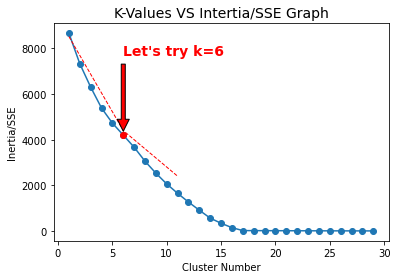

In [8]:
#plotting the kvalues vs inertia graph
plt.plot(k_cluster_range, inertia, 'o-')
plt.xlabel('Cluster Number')
plt.ylabel('Inertia/SSE')
plt.title('K-Values VS Intertia/SSE Graph', size=14)
#save the plot
#plt.savefig('elbow_method.png')

#plotting the red line and arrow
plt.plot([6], [inertia[5]], 'o--', color='red')
plt.plot([1,6,11], [8520, 4400,2400], '--', color='red', linewidth=1)
plt.annotate("Let's try k=6", xy=(6, inertia[5]), xytext=(6,7700),
             size=14, weight='bold', color='red',
             arrowprops=dict(facecolor='red', shrink=0.05))

Explained variance is 0.3122.


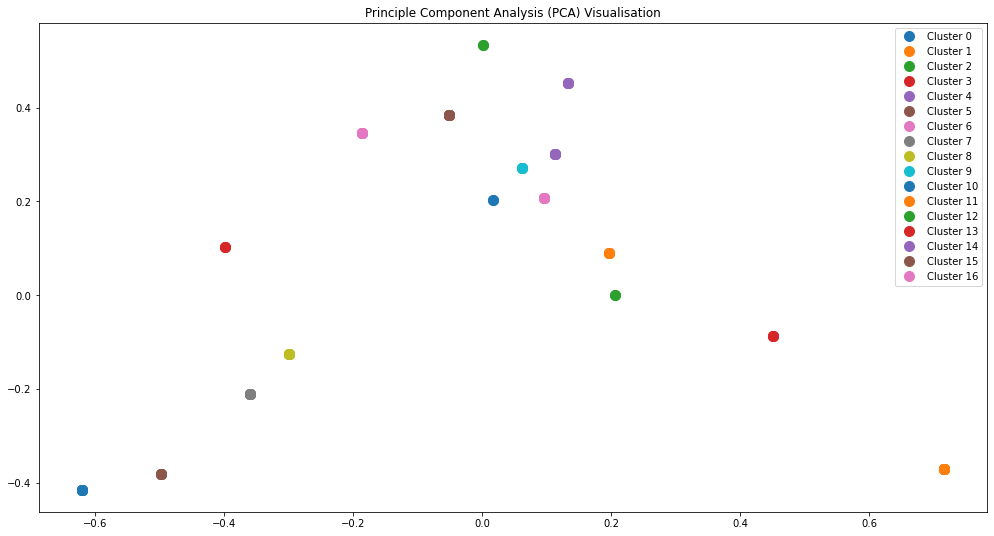

In [9]:
pca=PCA(n_components=2)
X_2d=pca.fit_transform(X.todense())

print('Explained variance is {}.'.format(round(pca.explained_variance_ratio_.sum(), 4)))

df = pd.DataFrame(dict(x=X_2d[:,0], y=X_2d[:,1], label=course_dataset['cluster'])) 
df_sample=df.sample(100)
groups = df_sample.groupby('label')

fig, ax = plt.subplots(figsize=(17, 9)) 
for cluster_name in np.arange(len(df_sample['label'].unique())):
    temp=df_sample[df_sample['label']==cluster_name]
    ax.plot(temp.x, temp.y, marker='o', linestyle='', ms=10, 
        label='Cluster '+str(cluster_name))
ax.legend(numpoints=1) 
plt.title('Principle Component Analysis (PCA) Visualisation')
plt.show()

### Course Dataset - Degree1, Degree1 Specializations & Key Skills

In [10]:
comb_frame = course_dataset.degree_1.str.cat(" " + course_dataset.degree_1_specializations.str.cat(" " + course_dataset.key_skills_str))
comb_frame = comb_frame.replace({"[^A-Za-z0-9 ]+": ""}, regex=True)

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(comb_frame)
X.shape #(10,000 x 69)

(10000, 69)

In [11]:
k_cluster_range = range(1,31)
inertia = np.zeros(len(k_cluster_range)) #sum of squares errors

for i in range(len(k_cluster_range)):
    kmeans = KMeans(n_clusters=i+1, init='k-means++', random_state=1234, max_iter=100).fit(X)
    comb_frame["clusters"] = kmeans.labels_
    inertia[i] = kmeans.inertia_

Text(0.5, 1.0, 'K-Values VS Intertia/SSE Graph')

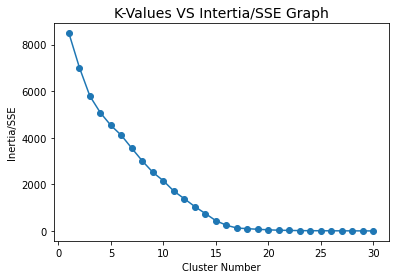

In [12]:
#plotting the kvalues vs inertia graph
plt.plot(k_cluster_range, inertia, 'o-')
plt.xlabel('Cluster Number')
plt.ylabel('Inertia/SSE')
plt.title('K-Values VS Intertia/SSE Graph', size=14)
#save the plot
#plt.savefig('elbow_method.png')

Explained variance is 0.3457.


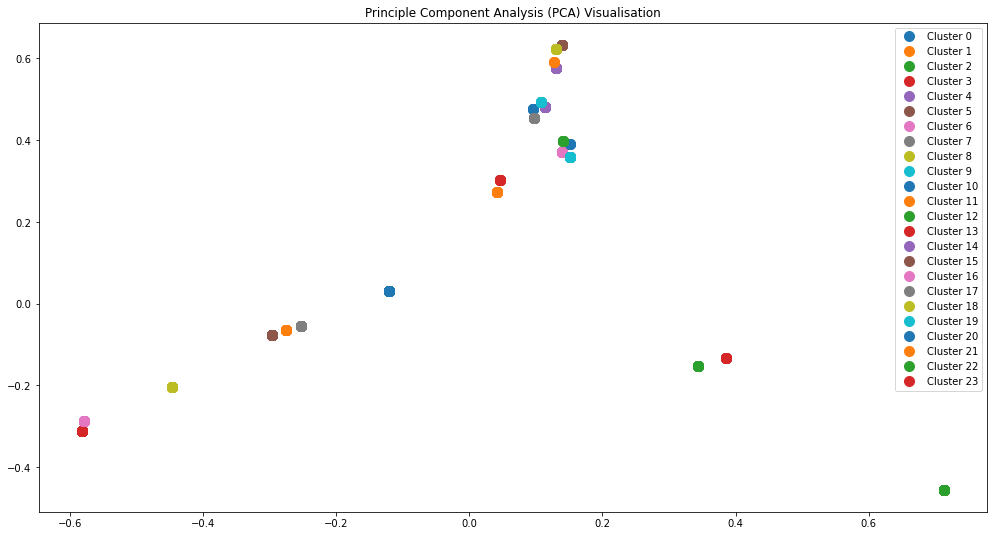

In [13]:
pca=PCA(n_components=2)
X_2d=pca.fit_transform(X.todense())

print('Explained variance is {}.'.format(round(pca.explained_variance_ratio_.sum(), 4)))

df = pd.DataFrame(dict(x=X_2d[:,0], y=X_2d[:,1], label=comb_frame["clusters"])) 
df_sample=df.sample(500)
groups = df_sample.groupby('label')

fig, ax = plt.subplots(figsize=(17, 9)) 
for cluster_name in np.arange(len(df_sample['label'].unique())):
    temp=df_sample[df_sample['label']==cluster_name]
    ax.plot(temp.x, temp.y, marker='o', linestyle='', ms=10, 
        label='Cluster '+str(cluster_name))
ax.legend(numpoints=1) 
plt.title('Principle Component Analysis (PCA) Visualisation')
plt.show()

#### The two different clusters we made seem identical even though the first is based solely on key skills and the second is a combination of key skills, degree specialization and degree type 

### User Dataset -  Key Skills

#### Trying different k values 

In [14]:
vectorizer = TfidfVectorizer(stop_words=set([",", "--", "-", "#", "&", "-c-"]),tokenizer=tokenize, max_features=1000)
X = vectorizer.fit_transform(user_dataset["key_skills_str"].values.astype('U'))

In [15]:
#k_cluster_range is the values of k we will loop through (from 1 to 30 seems common)
#try using smaller ranges to see that clustering is done correctly
k_cluster_range = range(1,5)
inertia = np.zeros(len(k_cluster_range)) #sum of squares errors

for i in range(len(k_cluster_range)):
    kmeans = KMeans(n_clusters=i+1, init='k-means++', random_state=1234).fit(X)
    inertia[i] = kmeans.inertia_
    
user_dataset['cluster']=kmeans.labels_

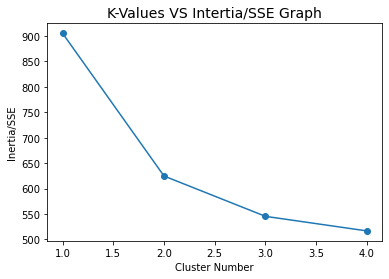

In [16]:
#plotting the kvalues vs inertia graph
plt.plot(k_cluster_range, inertia, 'o-')
plt.xlabel('Cluster Number')
plt.ylabel('Inertia/SSE')
plt.title('K-Values VS Intertia/SSE Graph', size=14)
plt.show()
#save the plot
#plt.savefig('elbow_method.png')

Explained variance is 0.4047.


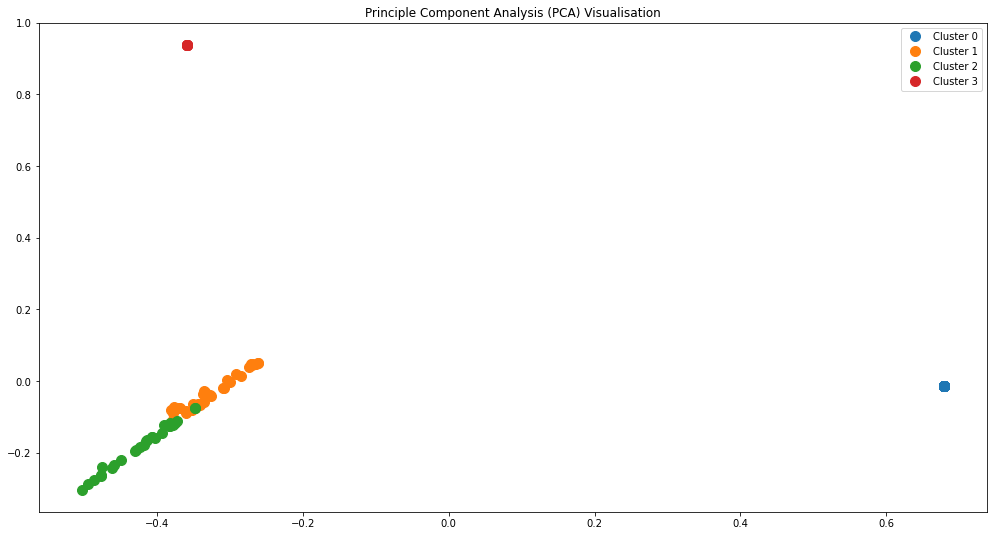

In [17]:
pca=PCA(n_components=2)
X_2d=pca.fit_transform(X.todense())

print('Explained variance is {}.'.format(round(pca.explained_variance_ratio_.sum(), 4)))

df = pd.DataFrame(dict(x=X_2d[:,0], y=X_2d[:,1], label=user_dataset['cluster'])) 
df_sample=df.sample(100)
groups = df_sample.groupby('label')

fig, ax = plt.subplots(figsize=(17, 9)) 
for cluster_name in np.arange(len(df_sample['label'].unique())):
    temp=df_sample[df_sample['label']==cluster_name]
    ax.plot(temp.x, temp.y, marker='o', linestyle='', ms=10, 
        label='Cluster '+str(cluster_name))
ax.legend(numpoints=1) 
plt.title('Principle Component Analysis (PCA) Visualisation')
plt.show()

### User Dataset -  Career Objective

#### Trying different k values 

In [18]:
vectorizer= TfidfVectorizer(stop_words=set([",", "--", "-", "#", "&", "-c-"]),tokenizer=tokenize, max_features=1000)
X=vectorizer.fit_transform(user_dataset["career_objective"].values.astype('U'))

In [19]:
#k_cluster_range is the values of k we will loop through (from 1 to 30 seems common)
k_cluster_range = range(1,30)
inertia = np.zeros(len(k_cluster_range)) #sum of squares errors

for i in range(len(k_cluster_range)):
    kmeans = KMeans(n_clusters=i+1, init='k-means++', random_state=1234).fit(X)
    inertia[i] = kmeans.inertia_
    
user_dataset['cluster']=kmeans.labels_

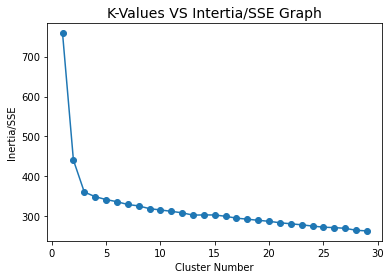

In [20]:
#plotting the kvalues vs inertia graph
plt.plot(k_cluster_range, inertia, 'o-')
plt.xlabel('Cluster Number')
plt.ylabel('Inertia/SSE')
plt.title('K-Values VS Intertia/SSE Graph', size=14)
plt.show()
#save the plot
#plt.savefig('elbow_method.png')

Explained variance is 0.527.


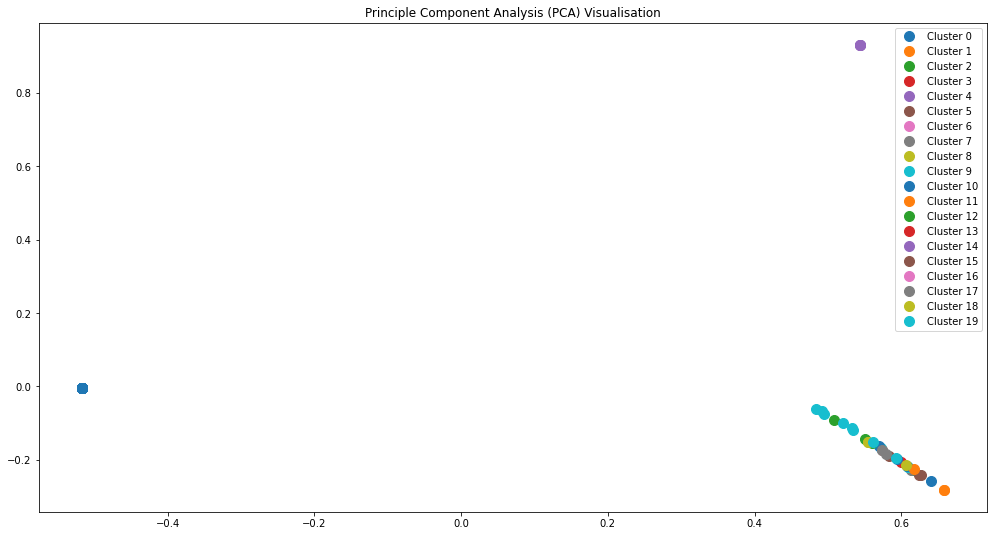

In [21]:
pca=PCA(n_components=2)
X_2d=pca.fit_transform(X.todense())

print('Explained variance is {}.'.format(round(pca.explained_variance_ratio_.sum(), 4)))

df = pd.DataFrame(dict(x=X_2d[:,0], y=X_2d[:,1], label=user_dataset['cluster'])) 
df_sample=df.sample(100)
groups = df_sample.groupby('label')

fig, ax = plt.subplots(figsize=(17, 9)) 
for cluster_name in np.arange(len(df_sample['label'].unique())):
    temp=df_sample[df_sample['label']==cluster_name]
    ax.plot(temp.x, temp.y, marker='o', linestyle='', ms=10, 
        label='Cluster '+str(cluster_name))
ax.legend(numpoints=1) 
plt.title('Principle Component Analysis (PCA) Visualisation')
plt.show()

### User Dataset -  Degree1 Specializations, Career Objective & Key Skills

In [22]:
comb_user_frame = user_dataset.degree_1_specializations.str.cat(" " + user_dataset.career_objective.str.cat(" " + user_dataset.key_skills_str))
comb_user_frame = comb_user_frame.replace({"[^A-Za-z0-9 ]+": ""}, regex=True)

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(comb_user_frame.values.astype('U'))
X.shape 

(1097, 1697)

In [23]:
k_cluster_range = range(1,31)
inertia = np.zeros(len(k_cluster_range)) #sum of squares errors

for i in range(len(k_cluster_range)):
    kmeans = KMeans(n_clusters=i+1, init='k-means++', random_state=1234, max_iter=100).fit(X)
    comb_user_frame["clusters"] = kmeans.labels_
    inertia[i] = kmeans.inertia_

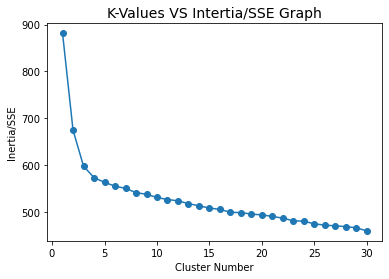

In [24]:
#plotting the kvalues vs inertia graph
plt.plot(k_cluster_range, inertia, 'o-')
plt.xlabel('Cluster Number')
plt.ylabel('Inertia/SSE')
plt.title('K-Values VS Intertia/SSE Graph', size=14)
plt.show()
#save the plot
#plt.savefig('elbow_method.png')

Explained variance is 0.3351.


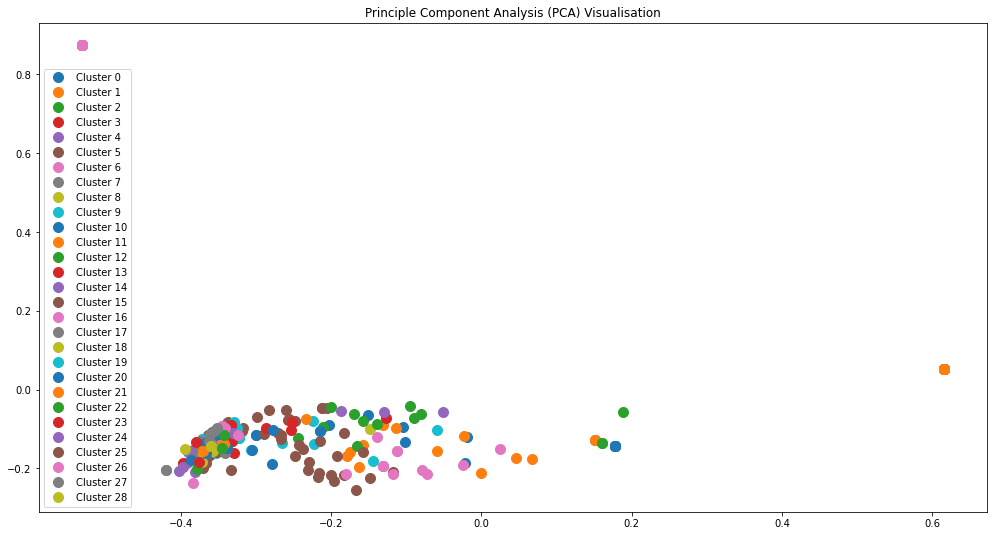

In [25]:
pca=PCA(n_components=2)
X_2d=pca.fit_transform(X.todense())

print('Explained variance is {}.'.format(round(pca.explained_variance_ratio_.sum(), 4)))

df = pd.DataFrame(dict(x=X_2d[:,0], y=X_2d[:,1], label=comb_user_frame["clusters"])) 
df_sample=df.sample(500)
groups = df_sample.groupby('label')

fig, ax = plt.subplots(figsize=(17, 9)) 
for cluster_name in np.arange(len(df_sample['label'].unique())):
    temp=df_sample[df_sample['label']==cluster_name]
    ax.plot(temp.x, temp.y, marker='o', linestyle='', ms=10, 
        label='Cluster '+str(cluster_name))
ax.legend(numpoints=1) 
plt.title('Principle Component Analysis (PCA) Visualisation')
plt.show()

## Collaborative Filtering

In [26]:
#Collaborative Filtering to make recommendations to Movie Watchers. 
#Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will 
#like a particular product or service those users have used/experienced but I have not.
#I will not be implementing Collaborative Filtering from scratch. Instead, I will use the Surprise library 
#that used extremely powerful algorithms like Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error)
#and give great recommendations.
#Implementation of SVD for surprise library is given on this link

Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response. It's the most important criterion for fit if the main purpose of the model is prediction.
Based on a rule of thumb, it can be said that RMSE values between **0.2 and 0.5** shows that the model can relatively predict the data accurately.

There is no correct value for MSE. Simply put, the lower the value the better and 0 means the model is perfect.

MAE: A metric that tells us the **mean absolute difference** between the predicted values and the actual values in a dataset. The lower the MAE, the better a model fits a dataset.

### Using Surprise and testing with different algorithms (SVD, KnnBasic, KnnBaseline, KnnWithMeans, KnnWithZScore) to find the best one to use based on MAE and RMAE scores. 

In [27]:
#using surprise
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings_df[['user_id','course_id','rating']], reader)

#split into training and test sets using 80:20 ratio
raw_ratings = data.raw_ratings
random.shuffle(raw_ratings)                

ratio = int(len(raw_ratings)*0.8)
train_raw = raw_ratings[:ratio] 
test_raw = raw_ratings[ratio:] 

data.raw_ratings = train_raw       
trainset = data.build_full_trainset() 
testset = data.construct_testset(test_raw)

#create dict for different models 
models=[SVD(), KNNBasic(), KNNBaseline(), KNNWithMeans(), KNNWithZScore()] 
results = {} #to store the scores

#perform cross validation of MAE and RMSE for all models
for model in models:
    #kfold set to 5
    crossval_scores = cross_validate(model, data, measures=["MAE","RMSE"], cv=5, n_jobs=-1)  
    
    #saving and renaming appropraitely
    result = pd.DataFrame.from_dict(crossval_scores).mean(axis=0).\
             rename({'test_mae':'MAE', 'test_rmse': 'RMSE', 'fit_time': 'Fit Time', 'test_time': 'Test Time'})
    results[str(model).split("algorithms.")[1].split("object ")[0]] = result
    
#printing all models results
all_models = pd.DataFrame.from_dict(results)
all_models.T.sort_values(by='RMSE') #models sorted by RMSE

,MAE,RMSE,Fit Time,Test Time
matrix_factorization.SVD,1.122313,1.486714,0.035870,0.045012
knns.KNNWithMeans,1.291420,1.648116,0.002606,0.021491
knns.KNNBaseline,1.297644,1.654446,0.005007,0.067526
knns.KNNWithZScore,1.312072,1.678644,0.006025,0.030138
knns.KNNBasic,1.327783,1.680552,0.002173,0.057098


####  Using the SVD model to generate collaborative filtering recommendations since it has the least MAE and RMSE results

In [28]:
def svd_cf_recommendations(user):
    
    ''' This function generates "get_recommend" number of book recommendations 
        using Singular value decomposition. The function needs as input two 
        different parameters:
        (1) user i.e., user for which recommendations need to be generated 
        (2) get_recommend i.e., number of recommendations to generate for the user
        Default values are: user=13552, get_recommend=10
    '''
    
    #usisng the "best" parameters found using the gridsearchcv method from experiments notebook 
    model = SVD(n_factors = 90, n_epochs = 20, lr_all = 0.005, reg_all = 0.2)
    model.fit(trainset)
    
    #building test set and predict the ratings
    testset = trainset.build_anti_testset()
    predictions = model.test(testset)
    
    #save into dataframe
    rating_predictions = pd.DataFrame(predictions)
    
    #find the top 30 predictions for given user
    user_predictions = rating_predictions[rating_predictions['uid'] == user].\
                         sort_values(by="est", ascending = False).head(30)
    
    #create recommendations array and append user predictions as recommendations
    recommendations = []
    recommendations.append(list(user_predictions['iid']))
    recommendations = recommendations[0]
    
    return(recommendations)

In [53]:
svd_cf_recommendations(1001)

[2200,
 2110,
 2279,
 2155,
 2230,
 2402,
 2277,
 2114,
 2202,
 2274,
 2088,
 2246,
 2403,
 2097,
 2145,
 2026,
 2122,
 2299,
 2212,
 2293,
 2224,
 2377,
 2314,
 2352,
 2339,
 2162,
 2347,
 2033,
 2015,
 2095]

In [57]:
svd_cf_recommendations(1200)

[]

## Content Based Filtering

In [30]:
#https://github.com/ry05/couReco/blob/master/recommender.py
#https://github.com/jalajthanaki/Movie_recommendation_engine/blob/master/Movie_recommendation_engine.ipynb

### User Dataset - Based on Career Objective and Key Skills

In [31]:
user_dataset.head(2)

,Unnamed: 0,userid,degree_1,degree_1_specializations,known_languages,key_skills,career_objective,key_skills_str,cluster
0,0,1001,B.E.,Computer Science & Engineering,"['English', ' Marathi', ' Hindi']","['C', ' Java', ' Keras', ' Flask', ' Deep Lear...",Computer Engineering student with good technic...,"C, Java, Keras, Flask, Deep Learning, Sel...",8
1,1,1002,B.E.,Computer Science & Engineering,['Hindi English'],"['Java', ' Neural Networks', ' AI', ' Python',...",Interested in working under company offering A...,"Java, Neural Networks, AI, Python, Html5, ...",9


In [39]:
#creating a new dataset dataset using the career objetcive, key skills and their user id
cf_user_dataset = pd.DataFrame()
cf_user_dataset['userid'] = user_dataset['userid']
cf_user_dataset['career_objective'] = user_dataset['career_objective']
cf_user_dataset['key_skills_str'] = user_dataset['key_skills_str']
cf_user_dataset.head(5)

#store the career objective and key skills in description
cf_user_dataset['description'] = cf_user_dataset['career_objective'] + cf_user_dataset['key_skills_str']
cf_user_dataset.head(5)

,userid,career_objective,key_skills_str,description
0,1001,Computer Engineering student with good technic...,"C, Java, Keras, Flask, Deep Learning, Sel...",Computer Engineering student with good technic...
1,1002,Interested in working under company offering A...,"Java, Neural Networks, AI, Python, Html5, ...",Interested in working under company offering A...
2,1003,Missing,Missing,MissingMissing
3,1004,Currently a final year student of Computer Eng...,"XML, C, Java, Data Structures, Python, Mo...",Currently a final year student of Computer Eng...
4,1005,To have a growth oriented and challenging care...,"XML, Word, Data Structures, Communication, ...",To have a growth oriented and challenging care...


In [40]:
#vectorize using countvectorize that converts into a matrix of token counts
user_count = CountVectorizer(stop_words='english', analyzer='word', ngram_range=(1, 2), min_df=0)
user_count_matrix = user_count.fit_transform(cf_user_dataset['description'].values.astype('U'))

#cosine similarity between the the matrix itself (normalized dot product of X and Y)
user_cosine_sim = cosine_similarity(user_count_matrix, user_count_matrix)

#create indices for the user is using series
cf_user_dataset = cf_user_dataset.reset_index()
user_ids = cf_user_dataset['userid']
indices = pd.Series(cf_user_dataset.index, index=cf_user_dataset['userid'])


#function to get content-filtered recommendations
def get_user_cf_recommendations(user):
    
    #get index of user
    user_id = indices[user]
    
    #find the most similar 30 users using cosine_sim and sorting with highest similarity
    sim_scores = list(enumerate(user_cosine_sim[user_id]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    user_indices = [i[0] for i in sim_scores]
    
    return user_ids.iloc[user_indices]

In [41]:
#getting the similar users recs for user 1001
get_user_cf_recommendations("1001")

894     1847
996     1946
93      1087
256     1231
201     1182
180     1161
91      1085
464     1416
981     1931
165     1146
457     1411
376     1338
868     1821
970     1920
1089    2039
653     1606
387     1349
212     1189
210     1187
110     1102
277     1252
47      1045
334     1304
941     1891
521     1473
123     1115
163     1144
536     1488
512     1464
267     1242
Name: userid, dtype: object

In [48]:
get_user_cf_recommendations("1847").head(10)

996    1946
0      1001
93     1087
981    1931
110    1102
256    1231
180    1161
91     1085
165    1146
201    1182
Name: userid, dtype: object

### Course Dataset - Based on Degree 1, Degree 1 Specialization and Key Skills

In [43]:
course_dataset.head(2)

,Unnamed: 0,sr_,degree_1,degree_1_specializations,campus,key_skills,key_skills_str,cluster
0,0,1001,B.E.,Mechanical,MITCOE,['CATIA'],CATIA,16
1,1,1002,B.E.,Mechanical,MITCOE,['CATIA'],CATIA,16


In [44]:
#creating a new dataset dataset using the degree1, degree1specializations and key skills and the course id
cf_course_dataset = pd.DataFrame()
cf_course_dataset['sr_'] = course_dataset['sr_']
cf_course_dataset['degree_1'] = course_dataset['degree_1']
cf_course_dataset['degree_1_specializations'] = course_dataset['degree_1_specializations']
cf_course_dataset['key_skills_str'] = course_dataset['key_skills_str']
cf_course_dataset.head(5)

#store the career objective and key skills in description
cf_course_dataset['description'] = cf_course_dataset['degree_1'] + cf_course_dataset['degree_1_specializations'] + cf_course_dataset['key_skills_str']
cf_course_dataset.head(5)

,sr_,degree_1,degree_1_specializations,key_skills_str,description
0,1001,B.E.,Mechanical,CATIA,B.E.MechanicalCATIA
1,1002,B.E.,Mechanical,CATIA,B.E.MechanicalCATIA
2,1003,B.E.,Mechanical,CATIA,B.E.MechanicalCATIA
3,1004,B.E.,Mechanical,CATIA,B.E.MechanicalCATIA
4,1005,B.E.,Mechanical,CATIA,B.E.MechanicalCATIA


In [49]:
#vectorize using countvectorize that converts into a matrix of token counts
course_count = CountVectorizer(stop_words='english', analyzer='word', ngram_range=(1, 2), min_df=0)
course_count_matrix = course_count.fit_transform(cf_course_dataset['description'].values.astype('U'))

#cosine similarity between the the matrix itself (normalized dot product of X and Y)
course_cosine_sim = cosine_similarity(course_count_matrix, course_count_matrix)

#create indices for the courses is using series
cf_course_dataset = cf_course_dataset.reset_index()
courses = cf_course_dataset['sr_']
indices = pd.Series(cf_course_dataset.index, index=cf_course_dataset['sr_'])

#function to get content-filtered recommendations
def get_course_cf_recommendations(course): 
    
    #get index of course
    course_id = indices[course]
    
    #find the most similar 30 courses using cosine_sim and sorting with highest similarity
    sim_scores = list(enumerate(course_cosine_sim[course_id]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    course_indices = [i[0] for i in sim_scores]
    
    return courses.iloc[course_indices]

In [50]:
#getting the similar course recs for course 1001
get_course_cf_recommendations(1001).head(10)

1     1002
2     1003
3     1004
4     1005
5     1006
6     1007
7     1008
8     1009
9     1010
10    1011
Name: sr_, dtype: int64

In [51]:
get_course_cf_recommendations(1003).head(10)

1     1002
2     1003
3     1004
4     1005
5     1006
6     1007
7     1008
8     1009
9     1010
10    1011
Name: sr_, dtype: int64

## The Hybrid Recommender 

This recommender will take as input the user and output a number of course recommendations for the user using a hybrid approach. The Collaborative Filtering model will be SVD and the Content Filtering is done using a CountVectorizer and similarity matrix.

To get the recommendations, courses that have been previously taken and considered completed by the user will be removed from the recommendations list.

Furthermore, the predictor will be developed after this is complete. 

Finally, the cluster technique might not be used since collaborative filtering was implemented using surprise

In [ ]:
#https://github.com/jalajthanaki/Movie_recommendation_engine/blob/master/Movie_recommendation_engine.ipynb

## Recommender

In [ ]:
#https://github.com/rochitasundar/Collaborative-Filtering-Book-Recommendation-System/blob/master/Book%20Recommendation%20Project.ipynb
#where i got the collab-filter

#https://github.com/SebastianRokholt/Hybrid-Recommender-System/blob/main/analysis-and-modelling.ipynb
#hybrid recommender

